## Text Pre-processing of question text data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [3]:
tr =train.isnull().sum()
te =test.isnull().sum()
print(tr)
print(te)


qid              0
question_text    0
target           0
dtype: int64
qid              0
question_text    0
dtype: int64


In [4]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


## VISUALISATION

C:\Users\vishnu vardhan reddy\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


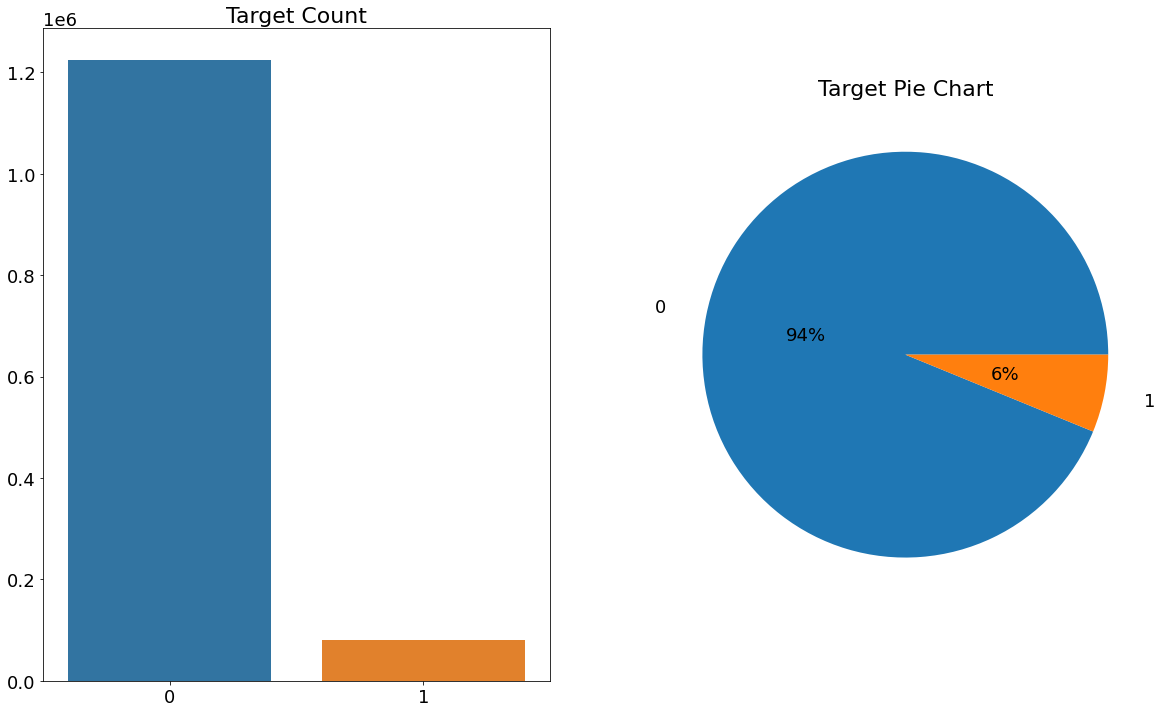

In [5]:
# bargraph and pie chart
cnt_srs = train['target'].value_counts()

plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,12))
sns.barplot(cnt_srs.index, cnt_srs.values, ax = ax[0])
ax[0].set_title('Target Count', fontsize=22)

sizes = (np.array((cnt_srs / cnt_srs.sum())*100))
labels = (np.array(cnt_srs.index))

ax[1].pie(sizes, labels=labels, autopct='%1.0f%%', pctdistance=.5, labeldistance=1.2)
ax[1].set_title('Target Pie Chart', fontsize=22)

plt.show()

## UNDER SAMPLING

In [6]:
# Class count
count_class_0, count_class_1 = train.target.value_counts()
count_class_0

1225312

In [7]:
sincere = train[train.target == 0]
insincere = train[train.target == 1]

Random under-sampling:
1    80810
0    80810
Name: target, dtype: int64


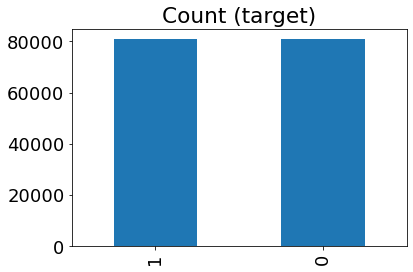

In [8]:
sincere_under = sincere.sample(count_class_1)
train = pd.concat([sincere_under,insincere], axis=0)
print('Random under-sampling:')
print(train.target.value_counts())

train.target.value_counts().plot(kind='bar', title='Count (target)');

## WORD CLOUD

In [9]:
#word cloud
from wordcloud import WordCloud, STOPWORDS
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(20.0,14.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

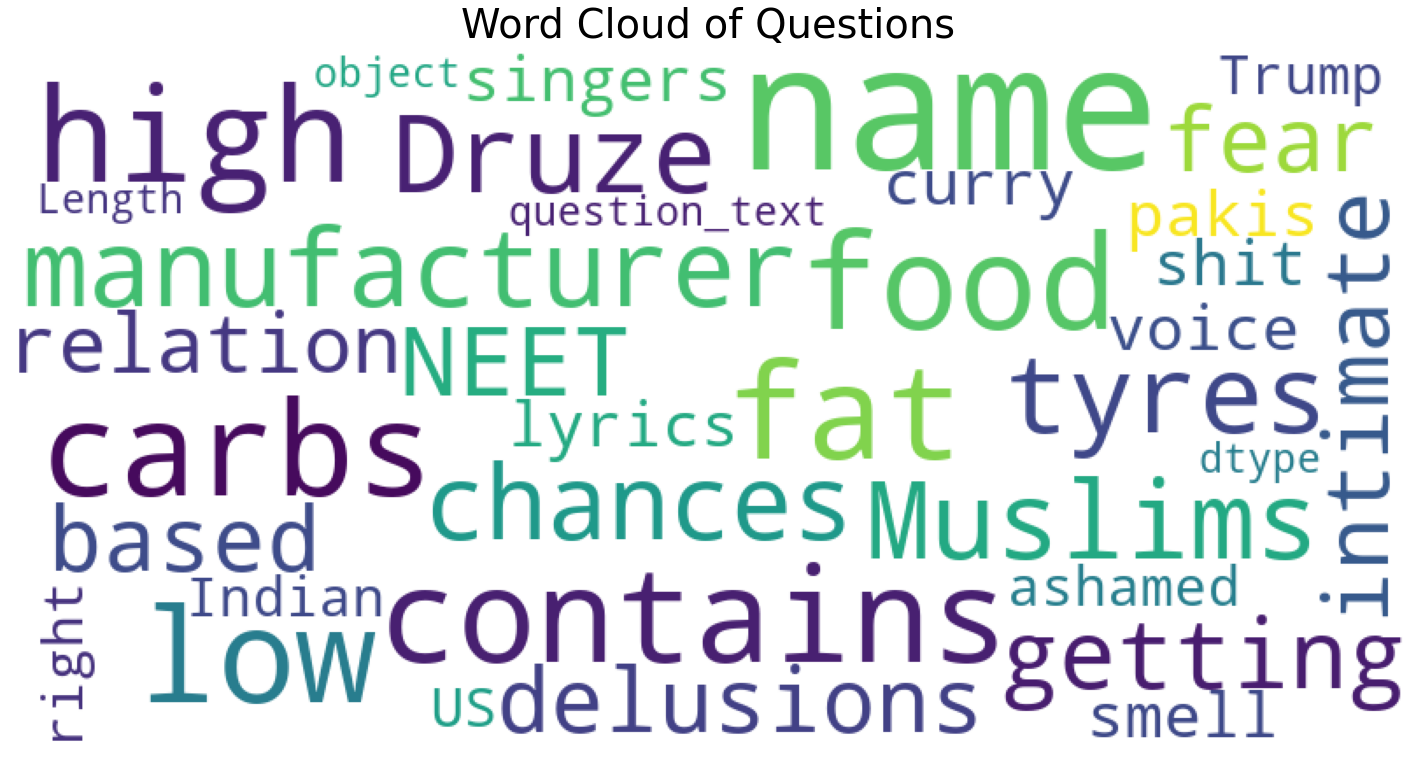

In [10]:
# input for the function 
plot_wordcloud(train["question_text"], title="Word Cloud of Questions")

In [11]:
ratio = (train.target.sum() / train.shape[0]) * 100
print("Insincere question ratio: ", ratio)

Insincere question ratio:  50.0


## DATA CLEANING

In [12]:
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')

wordnet_lemmatizer = WordNetLemmatizer()

def lemSentence(sentence):
    token_words = word_tokenize(sentence)
    lem_sentence = []
    for word in token_words:
        lem_sentence.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        lem_sentence.append(" ")
    return "".join(lem_sentence)

def clean_text(message, lem=True):
    # Remove ponctuation
    message = message.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    message = message.translate(str.maketrans('', '', string.digits))
    
    # Remove stop words
    message = [word for word in word_tokenize(message) if not word.lower() in nltk_stopwords]
    message = ' '.join(message)
    
    # Lemmatization (root of the word)
    if lem:
        message = lemSentence(message)
    
    return message

[nltk_data] Downloading package stopwords to C:\Users\vishnu vardhan
[nltk_data]     reddy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## TF-IDF VECTORIZATION

In [13]:
#TF-IDF vectorization
#TF-IDF vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, classification_report
vectorizer = TfidfVectorizer(lowercase=False, min_df=0.01, max_df=0.999)
# min_df & max_df param added for less memory usage

X= vectorizer.fit_transform(train['question_text'])

## DATA DISTRIBUTION

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, train['target'], test_size=0.2, random_state=42)

In [15]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

# calculate f1-score
def get_f1(model, name):
    y_train_pred, y_pred = model.predict(X_train), model.predict(X_test)
    print(classification_report(y_test, y_pred), '\n')
    print('{} model with F1 score = {}'.format(name, f1_score(y_test, y_pred)))
    

## MODELLING

## XGB WITH WEIGHTS

In [16]:
import xgboost as xgb
xgb = xgb.XGBClassifier(objective="binary:logistic", scale_pos_weight=ratio)
xgb.fit(X_train, y_train)
get_f1(xgb, 'XGBClassifier')

C:\Users\vishnu vardhan reddy\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.94      0.11      0.20     16107
           1       0.53      0.99      0.69     16217

    accuracy                           0.55     32324
   macro avg       0.74      0.55      0.45     32324
weighted avg       0.74      0.55      0.45     32324
 

XGBClassifier model with F1 score = 0.6912017167381975


## LGBM WITH WEIGHTS

In [17]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier(n_jobs = -1, class_weight={0:y_train.sum(), 1:len(y_train) - y_train.sum()})
lgb.fit(X_train, y_train)
get_f1(lgb, 'LGBM weighted')

              precision    recall  f1-score   support

           0       0.80      0.83      0.81     16107
           1       0.82      0.79      0.81     16217

    accuracy                           0.81     32324
   macro avg       0.81      0.81      0.81     32324
weighted avg       0.81      0.81      0.81     32324
 

LGBM weighted model with F1 score = 0.8062054454668216


## LGBM WITHOUT WEIGHTS

In [18]:
# test classification dataset
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
# summarize the dataset
print(X.shape, y.shape)

(1000, 20) (1000,)


In [19]:
# LGBM without weights  and using cross validation with different sets of distribution and took avg of all sets predictions
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
# define the model
model = LGBMClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.925 (0.031)


## XGB WITH OUT WEIGHTS

In [20]:
from xgboost import XGBClassifier
import xgboost as xgb1
xgb1 = xgb1.XGBClassifier(objective="binary:logistic")
xgb1.fit(X_train, y_train)
get_f1(xgb1, 'XGBClassifier')

[17:12:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\vishnu vardhan reddy\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



              precision    recall  f1-score   support

           0       0.80      0.83      0.81     16107
           1       0.82      0.79      0.81     16217

    accuracy                           0.81     32324
   macro avg       0.81      0.81      0.81     32324
weighted avg       0.81      0.81      0.81     32324
 

XGBClassifier model with F1 score = 0.8086882827458488


## PREDICTION

In [21]:
y_pred_final =xgb1.predict(X_test)
y_pred_final

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

## SAVING TRAINED MODEL

In [22]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, classification_report
vectorizer = TfidfVectorizer(lowercase=False, min_df=0.01, max_df=0.999)
X= vectorizer.fit_transform(train['question_text']).toarray()

In [23]:
X.shape

(161620, 160)

In [24]:
y =train['target']

In [25]:
y


506677     0
495331     0
893856     0
327245     0
217160     0
          ..
1306093    1
1306094    1
1306099    1
1306103    1
1306112    1
Name: target, Length: 161620, dtype: int64

In [31]:
vectorizer.get_feature_names()[:20]

['America',
 'American',
 'Americans',
 'Are',
 'Can',
 'Chinese',
 'Do',
 'Does',
 'How',
 'If',
 'India',
 'Indian',
 'Indians',
 'Is',
 'Muslim',
 'Muslims',
 'Quora',
 'Should',
 'Trump',
 'US']

In [32]:
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': False,
 'max_df': 0.999,
 'max_features': None,
 'min_df': 0.01,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, train['target'], test_size=0.2, random_state=42)

In [36]:
tfidf  = pd.DataFrame(X_train,columns = vectorizer.get_feature_names())

In [37]:
tfidf

,America,American,Americans,Are,Can,Chinese,Do,Does,How,If,...,with,without,women,work,world,would,year,years,you,your
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.313299,0.0,...,0.373162,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.608579,0.0,0.000000,0.000000
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
129292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.360578,0.0,0.000000,0.000000,0.0,0.000000,0.000000
129293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.572122,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
129294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.212043,0.000000,0.0,0.640726,0.212043


In [38]:
from xgboost import XGBClassifier
import xgboost as xgb1
xgb1 = xgb1.XGBClassifier(objective="binary:logistic")
xgb1.fit(X_train, y_train)
get_f1(xgb1, 'XGBClassifier')

C:\Users\vishnu vardhan reddy\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:21:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.80      0.83      0.81     16107
           1       0.82      0.80      0.81     16217

    accuracy                           0.81     32324
   macro avg       0.81      0.81      0.81     32324
weighted avg       0.81      0.81      0.81     32324
 

XGBClassifier model with F1 score = 0.8092655863084977


In [39]:
import joblib 
tf = vectorizer
XGB = xgb1
joblib.dump(tf, 'TF_model.pkl', protocol=2)
joblib.dump(XGB, 'XGB_model.pkl', protocol=2)

['XGB_model.pkl']

In [40]:
new_model = joblib.load('XGB_model.pkl')
new_tf = joblib.load('TF_model.pkl')


In [41]:
#new prediction
def pred2_new(text):
    
    text = new_tf.transform([text])
    result = new_model.predict(text)
#     final = result[0]
#     final = 'bad' if result[0]==1 else 'good'
    final = 'sincere' if result[0]==0 else 'insincere'

    return final

In [42]:
pred2_new('How did Quebec nationalists see their province as a nation in the 1960s?')


'sincere'